In [1]:
import numpy as np
from scipy.sparse.linalg import eigsh
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
import matplotlib
import matplotlib.pyplot as plt
import time
from scipy import sparse
import sys
np.set_printoptions(precision=16)
np.set_printoptions(threshold=sys.maxsize)
start_time = time.time()
# initialize variables
N = 6   # NEED TO BE CHANGED FOR DIFFERENT N
# Q is the dimension
Q = pow(2, N)


# decimal number to binary array function
def D2B(num):
    string = f'{num:1b}'
    result = np.zeros(N - len(string), int)

    for ele in string:
        result = np.append(result, int(ele))

    return result


# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

In [2]:
# initialize J matrix
J_matrix = np.zeros((N, N), dtype='float64')
B = 0.01  # Initial B value, cannot be zero due to deg when B=0 

'''

J_value = 1
J_matrix_alpha = 1
for i in range(N):
    for j in range(N):
        if j >= (i + 1):
            J_matrix[i][j] = J_value/pow(abs(i-j),J_matrix_alpha)

'''


J_matrix = 0.157552*np.array([[0,4.9640,2.6885,1.6748,1.1009,0.7214],[0,0,4.7138,2.7427,1.7331,1.1009],[0,0,0,4.6260,2.7427,1.6748],[0,0,0,0,4.7138,2.6885],[0,0,0,0,0,4.9640],[0,0,0,0,0,0]])

J_value = np.max(J_matrix)

In [3]:
# initialize H matrix
H_matrix = np.zeros((Q, Q), dtype='float64')

# start fill in the elements for H matrix by looping all 2^N states

for i in range(Q):
    state = D2B(i)
    spin = D2B(i)  # second copy for the non-diagonal elements to use
    # loop over N sites to change the state vector to either 1 or -1
    for j in range(N):
        # 1 is spin down , 0 is spin up
        if state[j] == 1:
            state[j] = -1
        else:
            state[j] = 1
    # now get the energy, loop all the sites and then pairs
    e_tot = 0
    for j in range(N):
        for q in range(N):
            e_temp = J_matrix[j][q] * state[j] * state[q]
            e_tot = e_tot + e_temp

    H_matrix[i][i] = e_tot

    # start calculating non diagonal elements
    for j in range(N):
        if spin[j] == 1:
            # if it's spin down, raise to spin up
            spin[j] = 0
            new_num = B2D(spin)
            H_matrix[i][new_num] = B
            # change it back for next operation
            spin[j] = 1
        else:
            # if it's spin down, raise to spin up
            spin[j] = 1
            new_num = B2D(spin)
            H_matrix[i][new_num] = B
            # change it back for next operation
            spin[j] = 0
            
## THERE SHOULD BE N*2^N B_values in the matrix 

In [4]:
i_list =[]
j_list =[]
for i in range(Q):
    for j in range(Q):
        if H_matrix[i][j] == 0.01:
            i_list.append(i)
            j_list.append(j)
            


In [5]:
# for spatial reflection, just read the state array backward and we will have the new state 
spatial_sym = np.empty(Q,dtype=int)
for i in range(Q):
    before_sym = D2B(i)
    after_sym = D2B(i) # to keep the same data format 
    for j in range(N):
        after_sym[j] = before_sym[N-j-1]
    spatial_num = int(B2D(after_sym))
    #  create a list append the new index
    spatial_sym[i]= spatial_num

In [6]:
# start looping for different B value 
dB=0.01
B_not =  J_value*5 # the biggest value of B, change the sign if we change FM TO AFM 
times = int(abs((B_not-B)/dB))
B_list = []
delta_e_list = []
for _ in range(0,times):
    vals, vecs = LA.eigh(H_matrix)
    vecs = np.transpose(vecs)
    inx = np.argsort(vals)
    # run sptaial reflection symmetry 
    new_state = np.empty(Q,dtype=complex)
    # get gs parity 
    temp_vec = vecs[inx[0]]
    for i in range(Q):
        new_state[i]= temp_vec[spatial_sym[i]]
    gs_parity_spatial = np.dot(temp_vec,new_state)
    # loop first N+5 excited state to get spatial parity number , note, the parity value is not 1 or -1 when PBC is apply
    couple_spatial_list = []
    for k in range(1,N+10):
        temp_vec = vecs[inx[k]]
        for j in range(Q):
            new_state[j]= temp_vec[spatial_sym[j]]
        parity_spatial = np.dot(temp_vec,new_state)
        #print('parity sptial is ',parity_spatial)
        if parity_spatial*gs_parity_spatial >0:
            couple_spatial_list.append(k)
    couple_spatial_list = np.array(couple_spatial_list)
    # run spin reflection symmetry 
    # get gs parity 
    temp_vec = vecs[inx[0]]
    for a in range(Q):
        new_state[a]= temp_vec[Q-1-a]
    gs_parity_spin = np.dot(temp_vec,new_state)
    # loop first N+5 excited state to get spin parity number
    couple_spin_list = []
    for c in range(1,N+10):
        temp_vec = vecs[inx[c]]
        for d in range(Q):
            new_state[d]= temp_vec[Q-1-d]
        parity_spin = np.dot(temp_vec,new_state)
        #print('parity spin is', parity_spin)
        if parity_spin*gs_parity_spin >0:
            couple_spin_list.append(c)
    couple_spin_list = np.array(couple_spin_list)
    
    first_couple = np.amin(np.intersect1d(couple_spatial_list,couple_spin_list))
    #print(first_couple)
    delta_enengy = vals[inx[first_couple]]- vals[inx[0]]
    #print(delta_enengy)
    delta_e_list.append(delta_enengy) 
    # update H matrix and B for next loop 
    H_matrix[H_matrix == B] = B+dB # AFM + , FM would be - , NEED CHANGE
    B_list.append(B)
    B = B + dB # AFM + , FM would be - , NEED CHANGE 

In [7]:
# calculate delta energy value from  0 to 0.01
B_nearzero_list=[]
de_nearzero_list=[]
H_matrix[H_matrix == B] = 0
B= 0
for _ in range(0,1): # change this 10 if we change dB
    vals, vecs = LA.eigh(H_matrix)
    inx = np.argsort(vals)
    delta_enengy = vals[inx[3]]- vals[inx[0]]
    # append values 
    de_nearzero_list.append(delta_enengy)
    # update H matrix and B for next loop 
    H_matrix[H_matrix == B] = B+dB # AFM + , FM would be - , NEED CHANGE 
    B_nearzero_list.append(B)
    B = B+dB # AFM + , FM would be - , NEED CHANGE 

In [8]:
B_nearzero_list = np.array(B_nearzero_list)
de_nearzero_list = np.array(de_nearzero_list)
# combine 2 lists together
B_total_list = np.concatenate((B_nearzero_list, B_list))
de_total_list = np.concatenate((de_nearzero_list, delta_e_list))

In [9]:
#plot_B_total_list =B_total_list/B_not
plot_B_total_list =B_total_list
#plot_de_total_list = de_total_list/B_not
plot_de_total_list = de_total_list

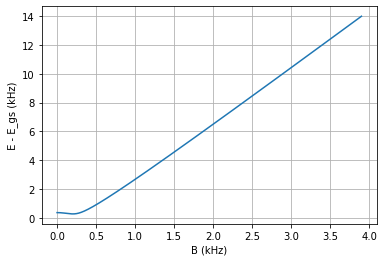

In [10]:
fig, ax = plt.subplots()
ax.plot(plot_B_total_list, (plot_de_total_list.real))
ax.set(xlabel='B (kHz)', ylabel=' E - E_gs (kHz) ')
#ax.set_xlim(0,2)
#ax.set_ylim(0,6)
ax.grid()
plt.show()

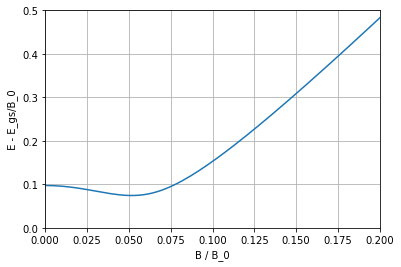

In [11]:
fig, ax = plt.subplots()
ax.plot(plot_B_total_list/B_not, (plot_de_total_list.real)/B_not)
ax.set(xlabel='B / B_0', ylabel=' E - E_gs/B_0 ')
ax.set_xlim(0,0.2)
ax.set_ylim(0,0.5)
ax.grid()
plt.show()

In [12]:
print('critical B value = ',plot_B_total_list[np.argmin(plot_de_total_list.real)])
print('critical B/B0 value = ',plot_B_total_list[np.argmin(plot_de_total_list.real)]/B_not)
print('critical delta energy value = ',np.min(plot_de_total_list.real))

critical B value =  0.20000000000000004
critical B/B0 value =  0.05114513130673684
critical delta energy value =  0.29128524865158445


In [13]:
# calculate t_f , total ramp time, set gamma to be 1
gamma = 1
#from scipy.integrate import simps
one_over_delta_square = pow(1/ de_total_list,2)
#t_f = gamma * simps(B_total_list, one_over_delta_square)
t_f = gamma * np.trapz(one_over_delta_square,x= B_total_list)
print('t_f is ', t_f)

t_f is  3.6579722476921273


In [14]:
# create reverse B field and de list to calcualte t_c from B_not
B_total_list_reversed = B_total_list[::-1]
B_integrate = np.array([B_total_list_reversed[0]])
one_over_delta_square_reversed = one_over_delta_square[::-1]
one_over_delta_square_integrate = np.array([one_over_delta_square_reversed[0]])

In [15]:
t_c_list = []
for i in range(1,len(B_total_list_reversed)):
    B_integrate = np.append(B_integrate,B_total_list_reversed[i])
    one_over_delta_square_integrate =  np.append(one_over_delta_square_integrate,one_over_delta_square_reversed[i])
    t_c = gamma * np.trapz(one_over_delta_square_integrate,x= B_integrate)
    t_c_list.append(t_c)

t_c_list = np.array(t_c_list)
t_c_list = -t_c_list /t_f # negative sign is to put time into postive or we can change the integral limit before

In [16]:
# becauase len(t_c_list) is one less than len(B_total_list_reversed) 
# I created a new list with old B field range but len(t_c_list) numbere of points 

final_B_range = abs(np.amax(B_total_list) - np.amin(B_total_list))
final_B = np.linspace(0, final_B_range , num=len(t_c_list), retstep=False)
plot_final_B = final_B/ final_B_range
plot_final_B = plot_final_B[::-1]

Text(0, 0.5, 'B / B_0')

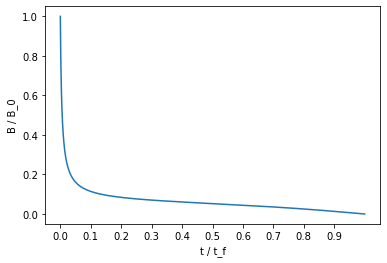

In [17]:
plt.plot(t_c_list.real,plot_final_B)
plt.xlabel('t / t_f')
#plt.xlim(0,1)
#plt.ylim(0,1)
plt.xticks(np.arange(0, 1, step=0.1))
plt.ylabel('B / B_0')

In [18]:
print("My program took", time.time() - start_time, "to run") 

My program took 1.1995229721069336 to run


In [19]:
#np.array((t_c_list*t_f).real)

In [20]:
#plot_final_B*final_B_range

In [21]:
#time_list = np.array((t_c_list*t_f).real)
time_list = np.array(t_c_list.real)

In [22]:
B_list = np.array(plot_final_B)

In [23]:
# turn B into a function of t, so that we can just change B later but not t 
bi = Akima1DInterpolator(time_list, B_list)
t_data_smooth = np.linspace(min(time_list), max(time_list), 1000)
B_data_smooth = bi(t_data_smooth)
dt = t_data_smooth[1]-t_data_smooth[0]
print('dt = ',dt)

dt =  0.0010009869551477562


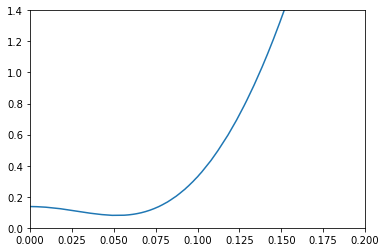

critical B/B0 value is  0.05271255589233683


In [24]:
plt.plot(B_data_smooth,-np.gradient(B_data_smooth,t_data_smooth))
plt.xlim(0,0.2)
plt.ylim(0,1.4)
plt.show()
print('critical B/B0 value is ', B_data_smooth[np.argmin(-np.gradient(B_data_smooth,t_data_smooth))])